In [117]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from S00_utils import loadPickle, plot_res, store_results

In [118]:
df = pd.read_excel("output/S21__2025-04-21-052727.xlsx")
df = df.set_index("Unnamed: 0")
df.index.names = ["id"]
df.head()

,m1,m2,m3,s1__autocorrelation__lag_8,s1__autocorrelation__lag_9,s1__autocorrelation__lag_7,s1__autocorrelation__lag_6,s1__autocorrelation__lag_5,s1__autocorrelation__lag_4,s1__longest_strike_above_mean,...,s1__ar_coefficient__coeff_3__k_10,s1__approximate_entropy__m_2__r_0.1,s1__lempel_ziv_complexity__bins_3,s1__partial_autocorrelation__lag_4,"s1__fft_coefficient__attr_""abs""__coeff_7","s1__agg_autocorrelation__f_agg_""var""__maxlag_40",s1__spkt_welch_density__coeff_2,y1,y2,y3
id,,,,,,,,,,,,,,,,,,,,,
E001,150.223716,1176.177278,1.142097,-0.305434,-0.519191,-0.074829,0.159896,0.385790,0.590387,14,...,0.183996,0.158567,0.204152,-0.360084,0.293617,0.499488,5.886812e-08,55.460434,1.065917,114.578620
E002,102.534268,1483.654982,1.104716,-0.243785,-0.454262,-0.021002,0.202836,0.416423,0.608972,14,...,0.184370,0.144742,0.203008,-0.344364,6.142373,0.477743,3.643621e-06,50.640306,1.285666,124.651484
E003,119.890549,1254.897451,2.162773,-0.329006,-0.543405,-0.095913,0.142612,0.373002,0.582151,14,...,0.184036,0.144268,0.208163,-0.364611,26.783283,0.506435,1.590028e-04,50.832405,1.154859,57.018054
E004,162.830799,1302.043195,1.308283,-0.065152,-0.266498,0.138913,0.337187,0.521401,0.683873,16,...,0.187213,0.137326,0.193662,-0.355441,33.227591,0.460547,7.926165e-04,62.476545,1.025161,132.221218
E005,165.720956,1154.482314,1.566830,-0.304881,-0.518177,-0.074836,0.159321,0.384728,0.589003,14,...,0.183978,0.128546,0.192440,-0.357588,11.439470,0.497940,1.462831e-04,57.634438,1.043776,92.160269


In [119]:
colsY = ["y1", "y2", "y3"]
colsX = [c for c in df.columns if c not in colsY]

dfX = df[colsX]
dfY = df[colsY]

In [120]:
dfData = loadPickle("output/S11__2025-04-21-052441.pickle")

In [121]:
dfData
tsArr = [t[1] for t in dfData["ts"].values]

In [122]:
# Max length
maxTime = 0
for ts in tsArr:
    maxTime = len(ts) if maxTime < len(ts) else maxTime

print(maxTime)

298


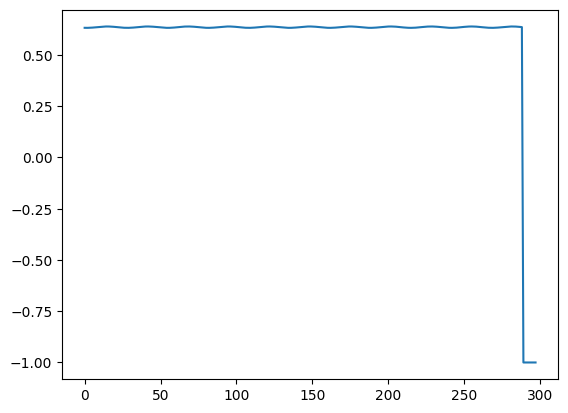

In [123]:
# Scaling and Padding
# TODO: Needs to only calculate mean, std, min, max from training example.

SCALING_TYPE = "Min_Max"
# SCALING_TYPE = "STANDARDIZATION"

tsArrConcat = np.concatenate(tsArr)
if SCALING_TYPE == "STANDARDIZATION":
    meanVal = np.mean(tsArrConcat)
    stdVal = np.std(tsArrConcat)
elif SCALING_TYPE == "Min_Max":
    maxVal = np.max(tsArrConcat)
    minVal = np.min(tsArrConcat)

# Shape = (Batch, Time, Features)
TsData_std = np.zeros((dfData.shape[0], maxTime, 1))
for idx, ts in enumerate(tsArr):
    if SCALING_TYPE == "STANDARDIZATION":
        ts_std = (ts - meanVal) / stdVal
    elif SCALING_TYPE == "Min_Max":
        ts_std = (ts - minVal) / (maxVal - minVal)

    TsData_std[idx, : len(ts), 0] = ts_std  # Scaling
    TsData_std[idx, len(ts) :, 0] = -1  # Padding

plt.plot(TsData_std[0, :])

In [124]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(random_state=0, test_size=0.30)
idxs = np.arange(df.shape[0])
idxTrain, idxTest = next(cv.split(X=idxs))
print(idxTrain)
print(idxTest)

[60 80 90 68 51 27 18 56 63 74  1 61 42 41  4 15 17 40 38  5 91 59  0 34
 28 50 11 35 23 52 10 31 66 57 79 85 32 84 14 89 19 29 49 97 98 69 20 94
 72 77 25 37 81 46 39 65 58 12 88 70 87 36 21 83  9 96 67 64 47 44]
[26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45 48  6 99 82 76]


In [125]:
dfX_train = dfX.iloc[idxTrain, :]
dfX_test = dfX.iloc[idxTest, :]
dfY_train = dfY.iloc[idxTrain, :]
dfY_test = dfY.iloc[idxTest, :]
Ts_train_std = TsData_std[idxTrain, :]
Ts_test_std = TsData_std[idxTest, :]

In [126]:
scX = MinMaxScaler()
X_train_std = scX.fit_transform(dfX_train)
X_test_std = scX.transform(dfX_test)

scY = MinMaxScaler()
Y_train_std = scY.fit_transform(dfY_train)
Y_test_std = scY.transform(dfY_test)

In [127]:
# Convert to 2D PyTorch tensors
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
Y_train_std = torch.tensor(Y_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)
Y_test_std = torch.tensor(Y_test_std, dtype=torch.float32)
Ts_train_std = torch.tensor(Ts_train_std, dtype=torch.float32)
Ts_test_std = torch.tensor(Ts_test_std, dtype=torch.float32)

In [128]:
class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        return h_n[-1]  # Return last hidden state of last layer


class TabularMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout=0.2):
        super().__init__()
        layers = []
        for i, h in enumerate(hidden_sizes):
            layers.append(nn.Linear(input_size if i == 0 else hidden_sizes[i - 1], h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)


class HybridModel(nn.Module):
    def __init__(
        self,
        ts_input_size,
        tab_input_size,
        lstm_hidden,
        mlp_hidden,
        num_layers,
        output_size,
        dropout=0.2,
    ):
        super().__init__()
        self.ts_processor = TimeSeriesLSTM(
            ts_input_size, lstm_hidden, num_layers, dropout
        )
        self.tab_processor = TabularMLP(tab_input_size, mlp_hidden, dropout)

        combined_size = lstm_hidden + mlp_hidden[-1] if mlp_hidden else lstm_hidden
        self.fc = nn.Sequential(
            nn.Linear(combined_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, output_size),
        )

    def forward(self, ts_data, tab_data):
        ts_features = self.ts_processor(ts_data)
        tab_features = self.tab_processor(tab_data)
        combined = torch.cat((ts_features, tab_features), dim=1)
        return self.fc(combined)

In [129]:
# Initialize model
model = HybridModel(
    ts_input_size=1,
    tab_input_size=dfX.shape[1],
    lstm_hidden=64,
    mlp_hidden=[128, 64],
    num_layers=2,
    output_size=3,
    dropout=0.2,
)

In [130]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

MSE: 0.00
RMSE: 0.05


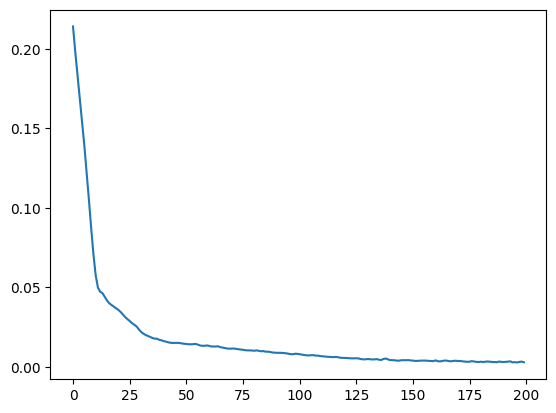

In [131]:
n_epochs = 200  # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train_std), batch_size)

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_std[start : start + batch_size]
            F_batch = Ts_train_std[start : start + batch_size]
            y_batch = Y_train_std[start : start + batch_size]
            # forward pass
            y_pred = model(F_batch, X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(Ts_test_std, X_test_std)
    mse = loss_fn(y_pred, Y_test_std)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [132]:
Y_train_pred = model(Ts_train_std, X_train_std)
Y_test_pred = model(Ts_test_std, X_test_std)

In [133]:
Y_train_std = Y_train_std.detach().numpy()
Y_test_std = Y_test_std.detach().numpy()
Y_train_pred = Y_train_pred.detach().numpy()
Y_test_pred = Y_test_pred.detach().numpy()

,MSE Train,MSE Test,R2 Train,R2 Test
0,0.002618,0.003901,0.941583,0.927203
1,0.002089,0.002972,0.945595,0.903878
2,0.001133,0.001238,0.980724,0.976377


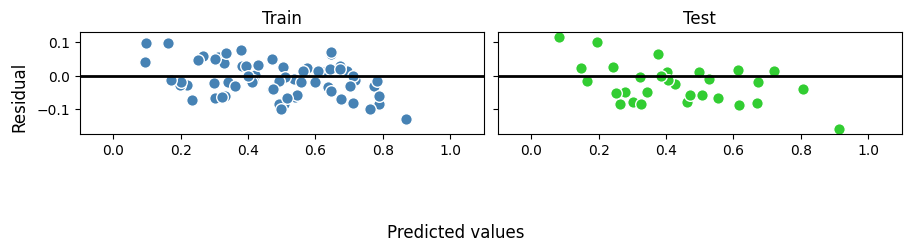

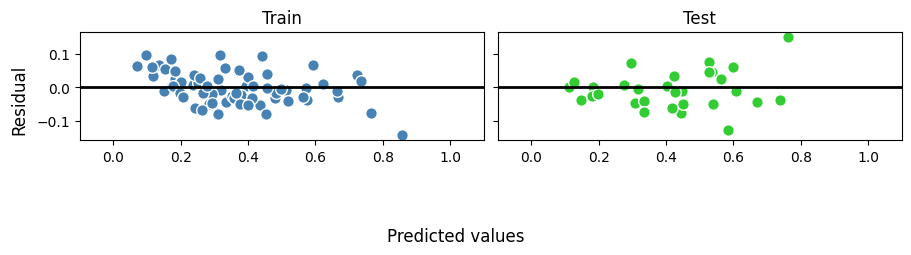

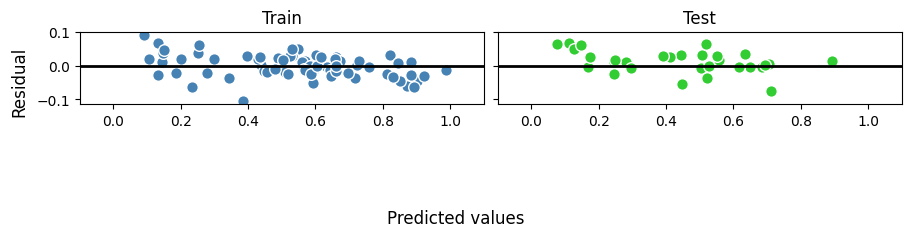

In [134]:
resArr = []
for i in range(dfY.shape[1]):
    y_train = Y_train_std[:, i]
    y_test = Y_test_std[:, i]
    y_train_pred = Y_train_pred[:, i]
    y_test_pred = Y_test_pred[:, i]
    plot_res(y_train, y_test, y_train_pred, y_test_pred, xlim=[-0.1, 1.1])
    res = store_results(y_train, y_test, y_train_pred, y_test_pred)
    resArr.append(res)

dfRes = pd.DataFrame.from_dict(resArr)
dfRes